In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [27]:
df = pd.read_csv("../CSVFiles/small50000DomainDataBertweetEmbedded.csv")

In [28]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [29]:
df = df.loc[:, ["comment_text", "split", "toxicity", "male", "female", "LGBTQ", "christian", "muslim", "other_religion", "black", "white"]]
df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

df['toxicity'] = df['toxicity'].apply(lambda text: np.round(text >= 0.5))
df['male'] = df['male'].apply(lambda x: np.round(x>=0.5))
df['female'] = df['female'].apply(lambda x: np.round(x>=0.5))
df['LGBTQ'] = df['LGBTQ'].apply(lambda x: np.round(x>=0.5))
df['christian'] = df['christian'].apply(lambda x: np.round(x>=0.5))
df['muslim'] = df['muslim'].apply(lambda x: np.round(x>=0.5))
df['other_religion'] = df['other_religion'].apply(lambda x: np.round(x>=0.5))
df['black'] = df['black'].apply(lambda x: np.round(x>=0.5))
df['white'] = df['white'].apply(lambda x: np.round(x>=0.5))

In [30]:
# Updating values for training_data
training_data = df[df['split'] == 'train']

# Getting test_data
test_data = df[df['split'] == 'test']

# Getting validation_data
validation_data = df[df['split'] == 'val']

In [31]:
X_train = training_data['comment_text'].values.tolist()
Y_train = training_data['toxicity'].values.tolist()

X_test = test_data['comment_text'].values.tolist()
Y_test = test_data['toxicity'].values.tolist()

X_val = validation_data['comment_text'].values.tolist()
Y_val = validation_data['toxicity'].values.tolist()

In [32]:
class AdalineGDPrivate():
    def __init__(self, learning_rate = 0.01, n_iter = 20, w = None):
        self.w = w
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        
    def CheckAccuracy(self, predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)
    
    def predict(self, X_test):
        # Making sure that array is numpy array
        X_test = np.array(X_test).reshape((len(X_test), -1))
        output = np.dot(X_test, self.w)
        # Sigmoid giving 0-1 results
        
        preds = np.round(1/(1+np.exp(-output)))
        return preds
    
    def PredictTestSetDemographic(self, dfTest):
        dic = {}
        for col in dfTest.columns[3:]:
            tempSet = dfTest[dfTest[col] == 1]
            tempLabels = tempSet['toxicity'].values.tolist()
            tempVecs = tempSet['comment_text'].values.tolist()
            dic[col] = [tempVecs, tempLabels]
        
        f1_scores = []
        for col in dic:
            tempPredictions = self.predict(dic[col][0])
            currentF1 = f1_score(dic[col][1], tempPredictions, zero_division=1)
            f1_scores.append([currentF1, col])
        
        f1_scores = np.array(f1_scores)
        return f1_scores
    
    def addNoise(self, X_train, eps):
        #Inspiration from https://www.researchgate.net/post/How-to-add-some-noise-data-to-my-classification-datasets
        #Find standard deviation
        std = np.std(X_train, axis=1)
        
        #Choose number to scale added noise by
        epsilon = eps
        
        #Add noise to each entrance in each row
        for i in range(len(std)):
            noise = np.random.uniform(-std[i], std[i], len(X_train[i]))
            X_train[i] += (noise * epsilon)
        return X_train
        
    def fit(self, X_train, Y_train, X_val, Y_val):
        # Making sure that arrays are numpy arrays
        
        X_train = np.array(X_train).reshape((len(X_train), -1))
        Y_train = np.array(Y_train).reshape((len(Y_train), 1))
        
        X_val = np.array(X_val).reshape((len(X_val), -1))
        Y_val = np.array(Y_val).reshape((len(Y_val), 1))
        
        # Initializing w vector using random normal distribution
        if self.w == None:
            self.w = np.random.normal(0, 0.1, len(X_train[0])).reshape(len(X_train[0]), 1)
        
        badEpoch = 0
        self.bestW = self.w
        bestAcc = 0
        early_stopping = 150
        
        self.TrainAccArr_ = []
        self.ValAccArr_ = []
        
        # Using n epochs
        for i in range(self.n_iter):
            #Add noise to traning data
            X_trainTemp = self.addNoise(X_train, 0.1)
            
            output = 1/(1+np.exp(-np.dot(X_trainTemp, self.w)))
            error = (Y_train - output)
            self.w += (1/len(Y_train)) * self.learning_rate * np.dot(X_trainTemp.T, error)
        
            tmpPredsVal = self.predict(X_val)
            valAcc = self.CheckAccuracy(tmpPredsVal, Y_val)
            self.ValAccArr_.append(valAcc)
            
            tmpPredsTrain = self.predict(X_train)
            TrainAcc = self.CheckAccuracy(tmpPredsTrain, Y_train)
            self.TrainAccArr_.append(TrainAcc)
            
            # Saving the best model and also checks for Early_Stopping
            if valAcc > bestAcc:
                bestAcc = valAcc
                badEpoch = 0
                self.bestW = self.w
            else:
                badEpoch += 1
            
            if badEpoch >= early_stopping:
                self.w = self.bestW                
                print("Stopped cause of bad Epoch in iteration: ", i)
                break
            #Print status
            if (i % 100) == 0:
                print('Iteration ', i, ' Done')
            #print(i)
                
        self.TrainAccArr_ = np.array(self.TrainAccArr_)
        self.ValAccArr_ = np.array(self.ValAccArr_)
        self.w = self.bestW
        return self

In [33]:
model = AdalineGDPrivate(learning_rate = 0.1, n_iter = 5000)

model.fit(X_train, Y_train, X_val, Y_val)
predictions = model.predict(X_test)

Y_test = np.array(Y_test).reshape(len(Y_test), 1)
model.CheckAccuracy(predictions, Y_test)

Iteration  0  Done
Iteration  100  Done
Iteration  200  Done
Iteration  300  Done
Iteration  400  Done
Iteration  500  Done
Iteration  600  Done
Iteration  700  Done
Stopped cause of bad Epoch in iteration:  741


0.6622516556291391

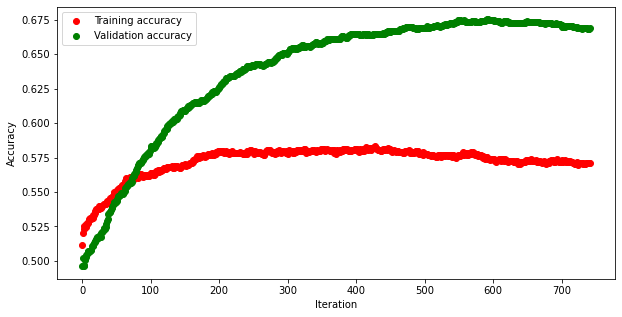

In [34]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(0,len(model.TrainAccArr_)), model.TrainAccArr_, color='r', label='Training accuracy')
plt.scatter(np.arange(0,len(model.ValAccArr_)), model.ValAccArr_, color='g', label='Validation accuracy')
#plt.title("Training loss vs Validation loss")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.savefig('BaselineClassifier accuracy Private')
plt.show()

In [35]:
forBarPlot = model.PredictTestSetDemographic(test_data)

In [36]:
np.std(forBarPlot[:,0].astype(float))

0.07233397578819839

[['0.665024630541872' 'male']
 ['0.6592427616926504' 'female']
 ['0.5701754385964912' 'LGBTQ']
 ['0.4933920704845815' 'christian']
 ['0.6363636363636362' 'muslim']
 ['0.5555555555555556' 'other_religion']
 ['0.717948717948718' 'black']
 ['0.6968973747016707' 'white']]


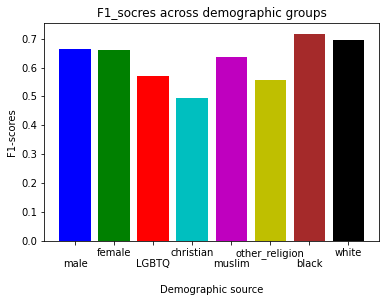

In [37]:
forBarPlot = model.PredictTestSetDemographic(test_data)
print(forBarPlot)
plt.figure()

x = forBarPlot[:,1]
for i in range(len(x)):
    if i%2 == 0:
        x[i] = "\n"+x[i]

y = np.array(forBarPlot[:,0].astype(float))

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color=['b', 'g', 'r', 'c', 'm', 'y', 'brown', 'k'])
plt.title('F1_socres across demographic groups')
plt.xlabel("\nDemographic source")
plt.ylabel("F1-scores")
plt.xticks(x_pos, x)
plt.savefig('FinalF1BaselineClassifierPrivate')
plt.show()

In [38]:
print(np.var(forBarPlot[:,0].astype(float)))
print(np.max(forBarPlot[:,0].astype(float)) - np.min(forBarPlot[:,0].astype(float)))

0.005232204053327671
0.22455664746413645
